## Eco Region Statistics

### This notebook is to calculate the area of each ecoregion covered by different hazards and asset.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import util

In [4]:
#path to clean data folder
clean_data = "../data/clean/"
raw_data = "../data/raw/"

In [3]:
## Read in data ###
# CA EPA eco regions
ecoregions = gpd.read_file(clean_data + "soco_ecoregion_l4/soco_ecoregion_l4.shp") 

# read in hazard data
flood_plains = gpd.read_file(clean_data + "flood_awareness_areas/flood_awareness_areas.shp")
wildfire_risk = gpd.read_file(clean_data + "soco_wildfire_risk_index/Wildfire_Risk_Index.shp")
slr_75 = gpd.read_file(clean_data + "fldhazd_slr75_w000/all_fldhazd_slr75_w000.shp")
slr_75_100 = gpd.read_file(clean_data + "fldhazd_slr75_w100/all_fldhazd_slr75_w100.shp")
slr_200 = gpd.read_file(clean_data + "fldhazd_slr200_w000/all_fldhazd_slr200_w000.shp")
ls_risk = gpd.read_file(clean_data + "soco_boundaries/City_Limits.shp")

# read in assets data
sonoma_veg_simp = gpd.read_file(clean_data + "sonoma_veg/sonoma_veg.shp")
landuse = gpd.read_file(raw_data + "soco_landuse/soco_landuse.shp") 

# Boundaries
soco_bound = gpd.read_file(clean_data + "sonoma_county_boundary/sonoma_county_boundary.shp")
cities = gpd.read_file(raw_data + "soco_boundaries/City_Limits.shp") 


### Initial Data Cleaning

In [21]:
## Simplify ecoregions
ecoregions['l4_simple'] = np.where(ecoregions['US_L4NAME'].isin({'Point Reyes/Farallon Islands', 'Marin Hills'}), 'Bodega Coastal Hills', ecoregions['US_L4NAME'])
ecoregions_simp = ecoregions[['l4_simple', 'geometry']]
ecoregions_simp = ecoregions_simp.dissolve(by = 'l4_simple', aggfunc='sum').reset_index()
ecoregions_simp['ecoregion_acres'] = ecoregions_simp['geometry'].area / 43560

In [38]:
ecoregions_simp

,l4_simple,geometry,Shape_Area,ALAND,AWATER
0,Bay Flats,"POLYGON ((6457375.369 1839801.158, 6458101.666...",2.967366e+08,4.080764e+09,4.981823e+08
1,Bodega Coastal Hills,"POLYGON ((6381082.225 1827591.674, 6379446.296...",1.262996e+09,2.040382e+10,2.490912e+09
2,Coastal Franciscan Redwood Forest,"POLYGON ((6199279.568 2057083.727, 6199127.431...",4.148158e+09,4.080764e+09,4.981823e+08
3,Fort Bragg/Fort Ross Terraces,"POLYGON ((6221139.364 1943186.149, 6221063.459...",4.834542e+08,4.080764e+09,4.981823e+08
4,Mayacmas Mountains,"POLYGON ((6343961.902 2057904.155, 6344919.458...",1.332374e+09,4.080764e+09,4.981823e+08
5,Napa-Sonoma-Lake Volcanic Highlands,"MULTIPOLYGON (((6400682.635 1951591.530, 64002...",1.391198e+09,8.161528e+09,9.963647e+08
6,Napa-Sonoma-Russian River Valleys,"POLYGON ((6271934.334 2073471.832, 6272744.838...",1.433998e+09,4.080764e+09,4.981823e+08
7,North Coast Range Eastern Slopes,"POLYGON ((6405821.549 1950568.891, 6405646.612...",1.660521e+08,4.080764e+09,4.981823e+08
8,Sonoma-Mendocino Mixed Forest,"POLYGON ((6266516.907 2073767.225, 6267442.639...",1.154900e+09,4.080764e+09,4.981823e+08


In [11]:
# make a column of wildfire risk on a 1-5 threshold 
wildfire_risk["risk_5_rank"] = wildfire_risk["TOTAL_RANK"] / 9
wildfire_risk["risk_5_rank"] = wildfire_risk["risk_5_rank"].round(0)

# dissolve by risk rank
fire_risk_simp = wildfire_risk[['risk_5_rank', 'geometry']]
fire_risk_simp = fire_risk_simp.to_crs(epsg=2226).dissolve(by="risk_5_rank").reset_index()

In [72]:
# dissolve floodplains data to simplify
floodplains_simp = flood_plains.dissolve()
floodplains_simp = floodplains_simp.filter(['geometry'])

In [89]:
# reproject and dissolve SLR data
slr_75_simp = slr_75.to_crs(epsg=2226).dissolve()
slr_75_100_simp = slr_75_100.to_crs(epsg=2226).dissolve()
slr_200_simp = slr_200.to_crs(epsg=2226).dissolve()

In [18]:
# dissolve sonoma veg by natural lifeform
veg_natural = sonoma_veg_simp[['natural_si', 'geometry']]
veg_natural = veg_natural.dissolve(by="natural_si").reset_index()

In [57]:
# dissolve by alliance/species groups
veg_alliance = sonoma_veg_simp[['MAP_CLASS', 'geometry']]
veg_alliance = veg_alliance.dissolve(by="MAP_CLASS").reset_index()

In [103]:
landuse_simp = landuse.dissolve(by="DESIGNATIO").reset_index()
landuse_simp = landuse_simp[["DESIGNATIO", "geometry"]]

In [106]:
# define function for creating a new column with the long form name of each landuse classification
name_map = {
    "DA": "Diverse Agriculture",
    "GC": "General Commercial",
    'GI': "General Industrial",
    'LC': "Limited Commercial",
    'LEA': "Land Extensive Agriculture",
    'LI': "Limited Industrial",
    'LIA': "Land Intensive Agriculture",
    'PQP': "Public / Quasi-public",
    'RR': "Rural Residential",
    'RRD': "Resources and Rural Development",
    'RVSC': "Recreation and Visitor Serving Commercial",
    'UR': "Urban Residential"
}

landuse_simp['landuse'] = landuse_simp["DESIGNATIO"].apply(lambda val: name_map[val])
landuse_simp = landuse_simp[['landuse', 'geometry']]
landuse_simp.head()

,landuse,geometry
0,Diverse Agriculture,"MULTIPOLYGON (((6306791.035 1877422.964, 63067..."
1,General Commercial,"MULTIPOLYGON (((6261752.617 1883713.133, 62617..."
2,General Industrial,"MULTIPOLYGON (((6356756.675 1904824.842, 63567..."
3,Limited Commercial,"MULTIPOLYGON (((6257794.500 1883038.542, 62578..."
4,Land Extensive Agriculture,"MULTIPOLYGON (((6281703.917 1885900.283, 62817..."


In [9]:
soco_bound = soco_bound.to_crs(epsg=2226)

### Zone statistics -- Hazards

##### Wildfire Risk

In [13]:
zones_wr = util.zone_intersect(ecoregions_simp, fire_risk_simp, 'fire_4_5')

In [14]:
zones_wr.head()

,l4_simple,risk_5_rank,fire_4_5
0,Bay Flats,1.0,246.052807
1,Bodega Coastal Hills,1.0,74.295240
2,Coastal Franciscan Redwood Forest,1.0,300.003662
3,Fort Bragg/Fort Ross Terraces,1.0,57.379936
4,Bay Flats,2.0,23237.103701


In [135]:
# filter and aggregate to just risk 4 and 5
zones_wr_4_5 = zones_wr[zones_wr["risk_5_rank"] >= 4]
zones_wr_4_5 = zones_wr_4_5.groupby('l4_simple').agg({'fire_4_5': 'sum'}).reset_index()
zones_wr_4_5

,l4_simple,fire_4_5
0,Bay Flats,214.531861
1,Bodega Coastal Hills,26031.038158
2,Coastal Franciscan Redwood Forest,50002.071619
3,Mayacmas Mountains,20827.083144
4,Napa-Sonoma-Lake Volcanic Highlands,63950.981746
5,Napa-Sonoma-Russian River Valleys,25839.968076
6,North Coast Range Eastern Slopes,7630.501730
7,Sonoma-Mendocino Mixed Forest,31286.707450


##### Floodplains

In [117]:
zones_fp = util.zone_intersect(ecoregions_simp, floodplains_simp, 'flood_awareness')
zones_fp.head()

,l4_simple,flood_awareness
0,Bay Flats,213.154481
1,Bodega Coastal Hills,2661.710699
2,Coastal Franciscan Redwood Forest,8043.842148
3,Fort Bragg/Fort Ross Terraces,822.435161
4,Mayacmas Mountains,3211.598899


##### SLR

In [99]:
zones_slr75 = util.zone_intersect(ecoregions_simp, slr_75_simp, 'slr_75cm').drop('FID', axis = 1)
zones_slr75_100yr = util.zone_intersect(ecoregions_simp, slr_75_100_simp, 'slr_75cm_100yr').drop('FID', axis = 1)
zones_slr200 = util.zone_intersect(ecoregions_simp, slr_200_simp, 'slr_200cm').drop('FID', axis = 1)

In [100]:
zones_slr75

,l4_simple,slr_75cm
0,Bay Flats,14087.822920
1,Bodega Coastal Hills,899.440760
2,Coastal Franciscan Redwood Forest,475.168292
3,Fort Bragg/Fort Ross Terraces,273.989892
4,Napa-Sonoma-Russian River Valleys,118.229447


#### Landslide Risk

In [133]:
ls_risk_8to10 = ls_risk[ls_risk["risk"] >= 8]
ls_risk_8to10 = ls_risk_8to10.drop('landslide_', axis = 1).set_crs("EPSG:3310", allow_override= True).to_crs(epsg=2226)
zone_ls_risk = util.zone_intersect(ecoregions_simp, ls_risk_8to10, 'ls_risk_8_10')

In [136]:
zone_ls_risk_sum = zone_ls_risk.groupby('l4_simple').agg({'ls_risk_8_10': 'sum'}).reset_index()
zone_ls_risk_sum

,l4_simple,ls_risk_8_10
0,Bay Flats,702.406358
1,Bodega Coastal Hills,40111.756047
2,Coastal Franciscan Redwood Forest,201919.550652
3,Fort Bragg/Fort Ross Terraces,5278.588355
4,Mayacmas Mountains,94163.667227
5,Napa-Sonoma-Lake Volcanic Highlands,82736.938753
6,Napa-Sonoma-Russian River Valleys,26918.908622
7,North Coast Range Eastern Slopes,11405.314789
8,Sonoma-Mendocino Mixed Forest,104048.692032


#### Bind ecoregion and hazard acres together into one dataframe

In [62]:
# Make dataframe with the total acres of each ecoreigon
ecoregion_area = ecoregions_simp.drop('geometry', axis = 1)
ecoregion_area

,l4_simple,ecoregion_acres
0,Bay Flats,31771.799491
1,Bodega Coastal Hills,89797.513014
2,Coastal Franciscan Redwood Forest,243527.483252
3,Fort Bragg/Fort Ross Terraces,24037.249709
4,Mayacmas Mountains,128342.895678
5,Napa-Sonoma-Lake Volcanic Highlands,124652.598843
6,Napa-Sonoma-Russian River Valleys,223194.335469
7,North Coast Range Eastern Slopes,13105.525900
8,Sonoma-Mendocino Mixed Forest,138833.291177


In [182]:
# join together all the data
from functools import reduce

hazard_ecoregions = reduce(lambda df1, df2: df1.join(df2.set_index('l4_simple'), on='l4_simple', how='outer'),
                            [zones_wr_4_5, zones_fp, zones_slr75, zones_slr75_100yr, zones_slr200, zone_ls_risk_sum],
                            ecoregion_area)


In [183]:
# replace NAs with 0 and add percentages for hazards
hazard_ecoregions = hazard_ecoregions.fillna(0)
hazard_ecoregions_with_pcts = hazard_ecoregions.join(hazard_ecoregions[hazard_ecoregions.columns.values[2:]].divide(hazard_ecoregions.ecoregion_acres, axis = 0) * 100, rsuffix="_pct")
hazard_ecoregions_with_pcts

,l4_simple,ecoregion_acres,fire_4_5,flood_awareness,slr_75cm,slr_75cm_100yr,slr_200cm,ls_risk_8_10,fire_4_5_pct,flood_awareness_pct,slr_75cm_pct,slr_75cm_100yr_pct,slr_200cm_pct,ls_risk_8_10_pct
0,Bay Flats,31771.799491,214.531861,213.154481,14087.822920,20955.577519,28432.575506,702.406358,0.675227,0.670892,44.340652,65.956533,89.489975,2.210786
1,Bodega Coastal Hills,89797.513014,26031.038158,2661.710699,899.440760,1275.239330,1288.307494,40111.756047,28.988596,2.964125,1.001632,1.420128,1.434681,44.669117
2,Coastal Franciscan Redwood Forest,243527.483252,50002.071619,8043.842148,475.168292,722.643800,506.149000,201919.550652,20.532414,3.303053,0.195119,0.296740,0.207841,82.914482
3,Fort Bragg/Fort Ross Terraces,24037.249709,0.000000,822.435161,273.989892,336.120349,329.703947,5278.588355,0.000000,3.421503,1.139855,1.398331,1.371638,21.960035
4,Mayacmas Mountains,128342.895678,20827.083144,3211.598899,0.000000,0.000000,0.000000,94163.667227,16.227687,2.502358,0.000000,0.000000,0.000000,73.368819
5,Napa-Sonoma-Lake Volcanic Highlands,124652.598843,63950.981746,2033.323566,0.000000,0.000000,0.000000,82736.938753,51.303368,1.631192,0.000000,0.000000,0.000000,66.374018
6,Napa-Sonoma-Russian River Valleys,223194.335469,25839.968076,27709.386326,118.229447,125.290672,1199.055415,26918.908622,11.577340,12.414915,0.052972,0.056135,0.537225,12.060749
7,North Coast Range Eastern Slopes,13105.525900,7630.501730,117.639866,0.000000,0.000000,0.000000,11405.314789,58.223545,0.897636,0.000000,0.000000,0.000000,87.026762
8,Sonoma-Mendocino Mixed Forest,138833.291177,31286.707450,1631.487167,0.000000,0.000000,0.000000,104048.692032,22.535450,1.175141,0.000000,0.000000,0.000000,74.945059


In [190]:
hazard_ecoregions_with_pcts = hazard_ecoregions_with_pcts.reindex(['l4_simple'] + sorted([x for x in hazard_ecoregions_with_pcts.columns if x != 'l4_simple']), axis = 1)
hazard_ecoregions_with_pcts

,l4_simple,ecoregion_acres,fire_4_5,fire_4_5_pct,flood_awareness,flood_awareness_pct,ls_risk_8_10,ls_risk_8_10_pct,slr_200cm,slr_200cm_pct,slr_75cm,slr_75cm_100yr,slr_75cm_100yr_pct,slr_75cm_pct
0,Bay Flats,31771.799491,214.531861,0.675227,213.154481,0.670892,702.406358,2.210786,28432.575506,89.489975,14087.822920,20955.577519,65.956533,44.340652
1,Bodega Coastal Hills,89797.513014,26031.038158,28.988596,2661.710699,2.964125,40111.756047,44.669117,1288.307494,1.434681,899.440760,1275.239330,1.420128,1.001632
2,Coastal Franciscan Redwood Forest,243527.483252,50002.071619,20.532414,8043.842148,3.303053,201919.550652,82.914482,506.149000,0.207841,475.168292,722.643800,0.296740,0.195119
3,Fort Bragg/Fort Ross Terraces,24037.249709,0.000000,0.000000,822.435161,3.421503,5278.588355,21.960035,329.703947,1.371638,273.989892,336.120349,1.398331,1.139855
4,Mayacmas Mountains,128342.895678,20827.083144,16.227687,3211.598899,2.502358,94163.667227,73.368819,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Napa-Sonoma-Lake Volcanic Highlands,124652.598843,63950.981746,51.303368,2033.323566,1.631192,82736.938753,66.374018,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Napa-Sonoma-Russian River Valleys,223194.335469,25839.968076,11.577340,27709.386326,12.414915,26918.908622,12.060749,1199.055415,0.537225,118.229447,125.290672,0.056135,0.052972
7,North Coast Range Eastern Slopes,13105.525900,7630.501730,58.223545,117.639866,0.897636,11405.314789,87.026762,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Sonoma-Mendocino Mixed Forest,138833.291177,31286.707450,22.535450,1631.487167,1.175141,104048.692032,74.945059,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [191]:
# save file
hazard_ecoregions_with_pcts.to_csv(clean_data + "hazard_ecoregion_stats.csv")

### Zone statistics -- Assets

##### Sonoma Veg

In [28]:
# flip order of intersection to keep natural simple column groups
zones_veg_nat = util.zone_intersect(veg_natural, ecoregions_simp, 'natural_lifeform')
zones_veg_nat.head()

,natural_si,l4_simple,natural_lifeform
0,Agriculture,Bay Flats,12643.143853
1,Aquatic Ecosystem,Bay Flats,12184.227528
2,Barren and Sparsely Vegetated,Bay Flats,553.715126
3,Developed,Bay Flats,532.716497
4,Forest,Bay Flats,168.403429


In [73]:
# get top 5 group types
zones_veg_nat_top = zones_veg_nat.sort_values(by="natural_lifeform", ascending=False).groupby(["l4_simple"]).head(5).sort_values(by = ["l4_simple",  "natural_lifeform"], ascending = False)

# get percentage each group type is
zones_veg_nat_top = zones_veg_nat_top.merge(ecoregion_area, how='left', on = 'l4_simple')
zones_veg_nat_top['percent_of_ecoregion'] = zones_veg_nat_top['natural_lifeform'] / zones_veg_nat_top['ecoregion_acres'] * 100

# Clean up for export
zones_veg_nat_top = zones_veg_nat_top.rename(columns = {'natural_lifeform': 'acres', 'l4_simple': 'ecoregion', 'natural_si': 'natural_lifeform'})
zones_veg_nat_top = zones_veg_nat_top[['ecoregion', 'natural_lifeform', 'acres', 'percent_of_ecoregion']]
zones_veg_nat_top.head()

,ecoregion,natural_lifeform,acres,percent_of_ecoregion
0,Sonoma-Mendocino Mixed Forest,Forest,99398.580030,71.595638
1,Sonoma-Mendocino Mixed Forest,Herbaceous,25960.520092,18.699060
2,Sonoma-Mendocino Mixed Forest,Shrub,5605.359860,4.037475
3,Sonoma-Mendocino Mixed Forest,Agriculture,3533.264689,2.544969
4,Sonoma-Mendocino Mixed Forest,Aquatic Ecosystem,2863.645801,2.062651


In [76]:
# save file
zones_veg_nat_top.to_csv(clean_data + "simple_veg_stats.csv")

In [74]:
# do the same with vegetation alliance data
zones_veg_all = util.zone_intersect(veg_alliance, ecoregions_simp, 'acres')
zones_veg_all_top = zones_veg_all.sort_values(by="acres", ascending=False).groupby(["l4_simple"]).head(5).sort_values(by = ["l4_simple",  "acres"], ascending = False)
zones_veg_all_top = zones_veg_all_top.merge(ecoregion_area, how='left', on = 'l4_simple')
zones_veg_all_top['percent_of_ecoregion'] = zones_veg_all_top['acres'] / zones_veg_all_top['ecoregion_acres'] * 100
zones_veg_all_top = zones_veg_all_top.rename(columns = {'l4_simple': 'ecoregion', 'MAP_CLASS': 'alliances'})
zones_veg_all_top = zones_veg_all_top[['ecoregion', 'alliances', 'acres', 'percent_of_ecoregion']]
zones_veg_all_top.head()

,ecoregion,alliances,acres,percent_of_ecoregion
0,Sonoma-Mendocino Mixed Forest,California Annual and Perennial Grassland Macr...,25951.994544,18.692919
1,Sonoma-Mendocino Mixed Forest,Quercus garryana Alliance,18598.470378,13.396261
2,Sonoma-Mendocino Mixed Forest,Pseudotsuga menziesii Alliance,16255.704281,11.708794
3,Sonoma-Mendocino Mixed Forest,"Quercus (agrifolia, douglasii, garryana, kello...",12295.012529,8.855954
4,Sonoma-Mendocino Mixed Forest,Umbellularia californica Alliance,9419.104144,6.784471


In [75]:
# save file
zones_veg_all_top.to_csv(clean_data + "all_veg_stats.csv")

#### Landuse

In [116]:
zones_landuse = util.zone_intersect(landuse_simp, ecoregions_simp, 'acres')
zones_landuse_top = zones_landuse.sort_values(by="acres", ascending=False).groupby(["l4_simple"]).head(5).sort_values(by = ["l4_simple",  "acres"], ascending = False)
zones_landuse_top['percent_of_ecoregion'] = zones_landuse_top['acres'] / zones_landuse_top['ecoregion_acres'] * 100
zones_landuse_top = zones_landuse_top.rename(columns = {'l4_simple': 'ecoregion'})
zones_landuse_top = zones_landuse_top[['ecoregion', 'landuse', 'acres', 'percent_of_ecoregion']]

In [118]:
zones_landuse_top.head()

,ecoregion,landuse,acres,percent_of_ecoregion
75,Sonoma-Mendocino Mixed Forest,Resources and Rural Development,102783.659760,74.033871
73,Sonoma-Mendocino Mixed Forest,Public / Quasi-public,16308.821634,11.747054
71,Sonoma-Mendocino Mixed Forest,Land Extensive Agriculture,12967.276356,9.340178
72,Sonoma-Mendocino Mixed Forest,Land Intensive Agriculture,5910.015821,4.256915
76,Sonoma-Mendocino Mixed Forest,Recreation and Visitor Serving Commercial,41.390249,0.029813


In [119]:
# save file
zones_landuse_top.to_csv(clean_data + "landuse_stats.csv")

In [13]:
soco_cities.head()

,STATEFP_1,PLACEFP,PLACENS,NAME_1,jurisdicti,Permits,ObjectID,COUNTYFP_1,COUNTYNS_1,COUNTYFP_1,STATEFP_2,COUNTYFP_2,COUNTYNS_2,AFFGEOID,GEOID,NAME_2,LSAD,ALAND,AWATER,geometry
0,06,70098,02411827,Santa Rosa,Santa Rosa,1026.0,398,None,None,None,06,097,01657246,0500000US06097,06097,Sonoma,06,4.080764e+09,498182342.0,"MULTIPOLYGON (((6340333.565 1930217.326, 63403..."
1,06,14190,02409487,Cloverdale,Cloverdale,86.0,80,None,None,None,06,097,01657246,0500000US06097,06097,Sonoma,06,4.080764e+09,498182342.0,"POLYGON ((6267902.721 2051300.451, 6269379.170..."
2,06,85922,02413495,Windsor,Windsor,91.0,472,None,None,None,06,097,01657246,0500000US06097,06097,Sonoma,06,4.080764e+09,498182342.0,"MULTIPOLYGON (((6344358.661 1957108.529, 63443..."
3,06,16560,02410240,Cotati,Cotati,68.0,97,None,None,None,06,097,01657246,0500000US06097,06097,Sonoma,06,4.080764e+09,498182342.0,"POLYGON ((6353143.203 1884123.400, 6353147.559..."
4,06,62546,02410985,Rohnert Park,Rohnert Park,1178.0,354,None,None,None,06,097,01657246,0500000US06097,06097,Sonoma,06,4.080764e+09,498182342.0,"POLYGON ((6353608.156 1892953.198, 6355975.608..."


#### Cities/Towns

<AxesSubplot:>

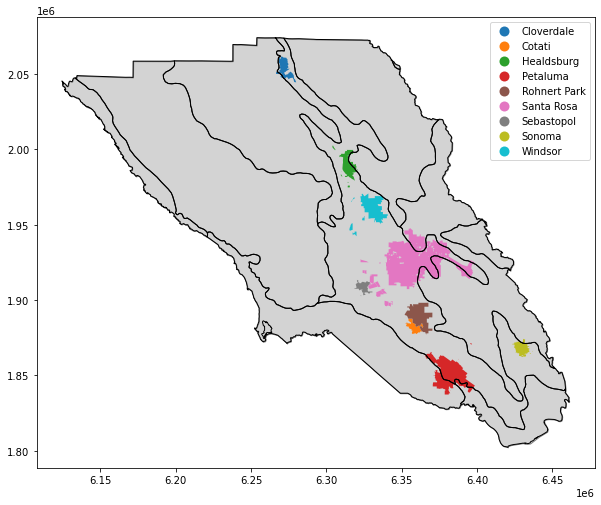

In [22]:
fig, ax = plt.subplots(figsize=(10,10))
soco_bound.plot(ax=ax, edgecolor = "grey", color = "#D3D3D3")
cities.plot(ax=ax, column = "CITY_NAME", legend = True)
ecoregions_simp.plot(ax=ax, color = "None")